In [37]:
import pickle
import numpy as np
import os, sys
%matplotlib inline
import matplotlib.pyplot as plt
import jp_mpl as jplot
from scipy import interpolate

In [2]:
run_nr = '101428'

In [5]:
new_dir = '/home/jpyanez/snoplus/data/laserball_runs/oca_mine'
ref_dir = '/sb/project/qbs-015-aa/jpyanez/data/SOC_histograms_python'

In [6]:
ref_data = pickle.load(open(os.path.join(ref_dir, 'SOC_0000' + run_nr + '.pckl')))

In [7]:
new_data = pickle.load(open(os.path.join(new_dir, 'SNOP_0000'+run_nr+'.pckl')))

In [8]:
ref_data.keys()

['residual_axis',
 'bin_width',
 'time_residuals',
 'manip_pos',
 'fit_pos',
 'wavelength',
 'pmt_delays',
 'soc_pmts']

In [9]:
new_data.keys()

['bin_width', 'time_residuals', 'residual_axis']

In [10]:
new_data['bin_width'], ref_data['bin_width']

(0.5, 0.5)

In [12]:
ref_data['time_residuals'].shape

(200, 9728)

In [28]:
# Check the number of hits in time window
ref_total = ref_data['time_residuals'].sum()
new_total = new_data['time_residuals'][1:,:].sum()
print 'Reference', ref_total
print 'New selection', new_total
print 'Fraction kept', new_total/ref_total


Reference 31323134.0
New selection 30779996.0
Fraction kept 0.98266016421


FWHM 4.14554204507


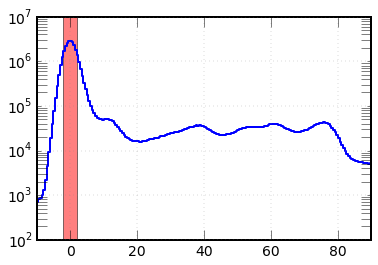

In [114]:
counts = ref_data['time_residuals'].sum(axis=1)
x = ref_data['residual_axis']

jplot.unfilledBar(x, counts)
plt.yscale('log')

spline = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., counts-counts.max()/2., s=0)
r1, r2 = spline.roots()

plt.axvspan(r1, r2, facecolor='r', alpha=0.5)
print 'FWHM', r2-r1

FWHM 4.19024387262


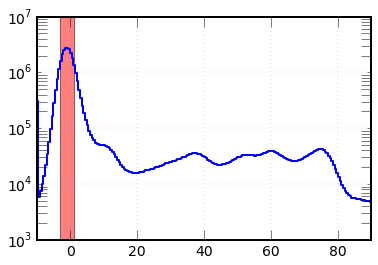

In [113]:
counts = new_data['time_residuals'].sum(axis=1)
x = new_data['residual_axis']

jplot.unfilledBar(x, counts)
plt.yscale('log')

spline = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., counts-counts.max()/2., s=0)
r1, r2 = spline.roots()

plt.axvspan(r1, r2, facecolor='r', alpha=0.5)
print 'FWHM', r2-r1

(10000, 3162277.6601683795)

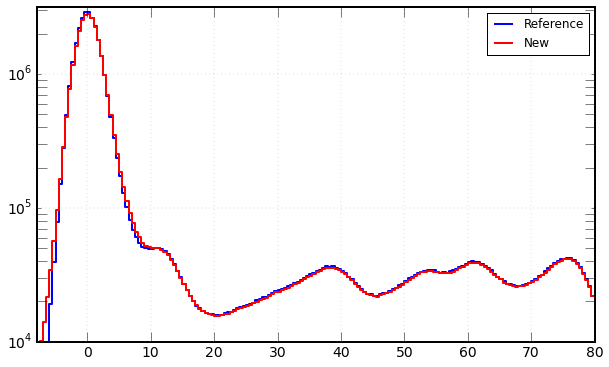

In [308]:
plt.figure(figsize=(10,6))
counts = ref_data['time_residuals'].sum(axis=1)
x = ref_data['residual_axis']

jplot.unfilledBar(x, counts, label='Reference')
plt.yscale('log')

counts = new_data['time_residuals'].sum(axis=1)
x = new_data['residual_axis']

jplot.unfilledBar(x+1., counts, label = 'New', color = 'red')
plt.legend(loc=0)
plt.xlim(-8, 80)
plt.ylim(10**4, 10**6.5)

In [291]:
# Obtaining the FWHM of the new
def getAllFWHM(data, logmode = False):
    bad_counter = 0
    fwhm = np.zeros(data['time_residuals'].shape[1])
    x = data['residual_axis']
    for pmtid in range(data['time_residuals'].shape[1]):
        if pmtid % 1000 == 0:
            print 'PMT ', pmtid
        if data['time_residuals'][:,pmtid].sum() < 5: 
            continue
        if logmode:
            c = np.log10(data['time_residuals'][:,pmtid])
            c[0] = 0.
            c[c==-np.inf] = 0.
            
            logc = c - c.max()/2.

            
            spline = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., 
                        logc, 
                        s=1)
        else:
            c = data['time_residuals'][:,pmtid]-data['time_residuals'][:,pmtid].max()/2.
            c[0] = 0.
            #print np.sum(c)
            spline = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., 
                        c, s=1)

        try:
            roots = spline.roots()
            fwhm[pmtid] = roots[1]-roots[0]
        except:
            bad_counter += 1
            #print 'Problem', pmtid, roots
            #jplot.unfilledBar(data['residual_axis'],
            #                  logc,
            #            color = 'green')
            #plt.show()
            #raw_input()
            #return spline
    print bad_counter
    return fwhm

In [292]:
ref_fwhm = getAllFWHM(ref_data)

PMT  0
PMT  1000
PMT  2000
PMT  3000
PMT  4000
PMT  5000
PMT  6000
PMT  7000
PMT  8000
PMT  9000
0


In [293]:
new_fwhm = getAllFWHM(new_data)

PMT  0
PMT  1000
PMT  2000
PMT  3000
PMT  4000
PMT  5000
PMT  6000
PMT  7000
PMT  8000
PMT  9000
0


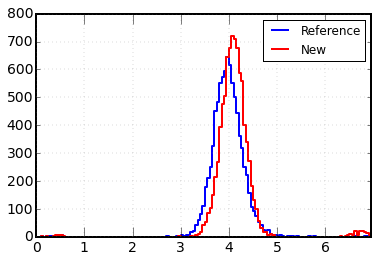

In [294]:
xaxis = np.arange(0., 7., 0.05)
b, x = np.histogram(ref_fwhm[ref_fwhm>0], xaxis)
bn, x = np.histogram(new_fwhm[ref_fwhm>0], xaxis)

jplot.unfilledBar(x,b, label='Reference')
jplot.unfilledBar(x,bn, color = 'red', label='New')
plt.legend(loc=0)

In [310]:
print np.median(ref_fwhm), np.median(new_fwhm)

3.93297845599 4.06120276027


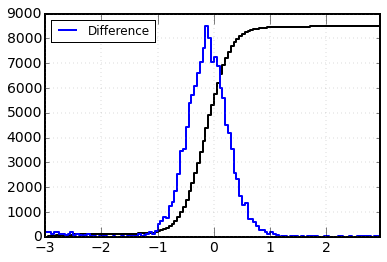

In [296]:
xaxis = np.arange(-3., 3., 0.05)
logdiff = ref_fwhm - new_fwhm
nonzero = (new_fwhm>0)*(ref_fwhm>0)
b, x = np.histogram(logdiff[nonzero], xaxis)

jplot.unfilledBar(x, np.cumsum(b), color = 'k')
jplot.unfilledBar(x,b*b.sum()/b.max(), label='Difference')

#plt.ylim(0, 2000)
plt.legend(loc=0)

In [297]:
# Look for a PMT with a large difference here
diff = np.where((logdiff > 2.)& (new_fwhm_log > 0) & (ref_fwhm_log>0))[0]
print diff.shape
print diff

(137,)
[ 143  225  230  251  308  406  487  892 1115 1319 1364 1412 1560 1570 1592
 1716 1724 1895 1947 1963 2106 2163 2170 2183 2189 2199 2363 2390 2535 2536
 2601 2621 2754 2799 2810 2858 2862 2964 3020 3190 3389 3468 3474 3497 3642
 3661 3681 3682 3759 3770 3888 3926 3975 4141 4203 4235 4365 4417 4516 4538
 4709 4816 4861 4882 5077 5174 5177 5178 5273 5338 5356 5399 5443 5466 5483
 5622 5624 5651 5804 5864 6026 6183 6254 6291 6353 6453 6457 6465 6483 6500
 6641 6686 6709 6838 6864 6886 6894 7105 7248 7265 7467 7628 7694 7705 7719
 7760 7819 7861 7871 7900 7951 7954 8129 8202 8274 8377 8434 8443 8485 8582
 8610 8781 8883 8893 9005 9006 9025 9039 9082 9158 9334 9419 9491 9506 9522
 9641 9679]


In [249]:
ref_fwhm_log = getAllFWHM(ref_data, logmode=True)

PMT  0
PMT  1000
PMT  2000
PMT  3000
PMT  4000
PMT  5000
PMT  6000
PMT  7000
PMT  8000
PMT  9000
0


/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [264]:
new_fwhm_log = getAllFWHM(new_data, logmode = True)

PMT  0
PMT  1000
PMT  2000
PMT  3000
PMT  4000
PMT  5000
PMT  6000
PMT  7000
PMT  8000
PMT  9000
101


/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log10


In [269]:
print 'Nonzeros', np.sum(ref_fwhm_log>0), np.sum(new_fwhm_log>0)
print 'Max', ref_fwhm_log.max(), new_fwhm_log.max()

Nonzeros 8678 8891
Max 49.4303569426 18.5086438341


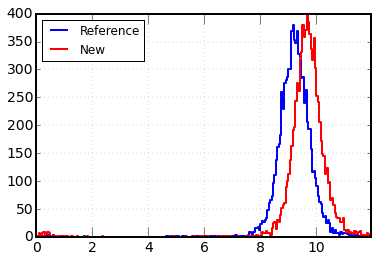

In [271]:
xaxis = np.arange(0., 12., 0.05)
b, x = np.histogram(ref_fwhm_log[ref_fwhm_log>0], xaxis)
bn, x = np.histogram(new_fwhm_log[ref_fwhm_log>0], xaxis)

jplot.unfilledBar(x,b, label='Reference')
jplot.unfilledBar(x,bn, color = 'red', label='New')
#plt.ylim(0, 2000)
plt.legend(loc=0)

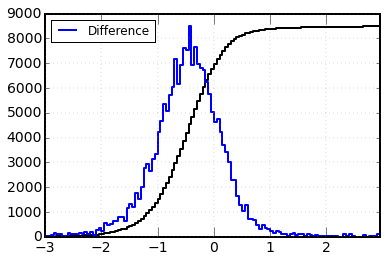

In [273]:
xaxis = np.arange(-3., 3., 0.05)
logdiff = ref_fwhm_log - new_fwhm_log
nonzero = (new_fwhm_log>0)*(ref_fwhm_log>0)
b, x = np.histogram(logdiff[(new_fwhm_log>0)*(ref_fwhm_log>0)], xaxis)

jplot.unfilledBar(x, np.cumsum(b), color = 'k')
jplot.unfilledBar(x,b*b.sum()/b.max(), label='Difference')

#plt.ylim(0, 2000)
plt.legend(loc=0)

In [274]:
np.sum(nonzero)

8678

In [285]:
# Look for a PMT with a large difference here
diff = np.where((logdiff > 2.)& (new_fwhm_log > 0) & (ref_fwhm_log>0))[0]
print diff.shape
print diff

(160,)
[  38  111  159  322  363  437  457  484  487  500  502  509  625  653  793
  804  859  967 1056 1066 1069 1070 1071 1075 1076 1077 1078 1083 1320 1333
 1334 1335 1341 1534 1711 2079 2170 2265 2368 2383 2446 2458 2465 2535 2567
 2754 2764 2769 2770 2796 2870 2925 2949 2971 3089 3377 3378 3581 3588 3609
 3681 3684 3685 3687 3689 3699 3701 3702 3703 3705 3709 3711 3964 3989 4015
 4141 4235 4242 4366 4389 4395 4399 4405 4549 4862 5138 5141 5143 5145 5146
 5150 5168 5243 5273 5394 5529 5619 5651 5652 5653 5656 5660 5663 5712 5976
 6227 6233 6253 6272 6301 6325 6397 6461 6504 6527 6545 6548 6550 6557 6572
 6610 6680 6686 6712 6724 6829 6836 6845 6868 6880 6987 7021 7080 7090 7229
 7274 7307 7442 7508 7694 7906 7944 8028 8167 8176 8179 8274 8358 8485 8587
 8693 8770 8832 9048 9050 9082 9307 9450 9460 9488]


In [286]:
logdiff[111]

10.117400252203517

9.02950890302 9.44671509167
[-3.73155084  5.32578108] [-3.87722889  5.59494613]
9.05733191558 9.47217501874


/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


(-10, 80)

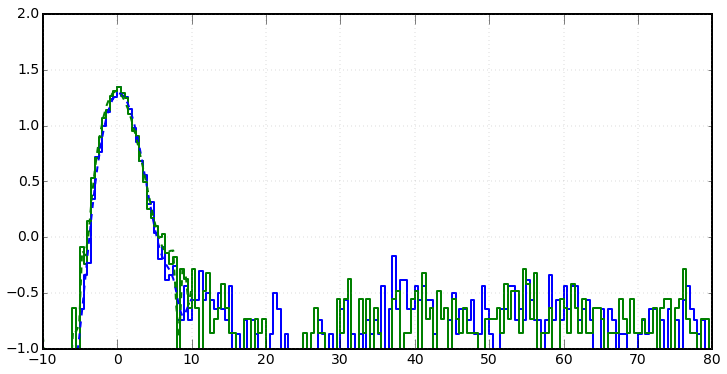

In [298]:
# Check the whole thing
pmtid = 143

print ref_fwhm_log[pmtid], new_fwhm_log[pmtid]

ref_counts = np.log10(ref_data['time_residuals'][:,pmtid])
new_counts = np.log10(new_data['time_residuals'][:,pmtid])
new_counts[0] = 0.


ref_counts[ref_counts==-np.inf] = 0
new_counts[new_counts==-np.inf] = 0


new_counts *= ref_counts.max()/new_counts.max()



plt.figure(figsize=(12,6))
jplot.unfilledBar(ref_data['residual_axis'] - ref_data['residual_axis'][ref_counts.argmax()],
                 ref_counts-ref_counts.max()/2., color = 'blue')
jplot.unfilledBar(new_data['residual_axis'] - new_data['residual_axis'][new_counts.argmax()],
                 new_counts-new_counts.max()/2., color = 'green')


x = ref_data['residual_axis'] - ref_data['residual_axis'][ref_counts.argmax()]
spline_ref = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., 
                        ref_counts - ref_counts.max()/2., 
                        s=2)

x = new_data['residual_axis'] - new_data['residual_axis'][new_counts.argmax()]
spline_new = interpolate.UnivariateSpline((x[1:]+x[:-1])/2., 
                        new_counts - new_counts.max()/2., 
                        s=2)

newx = np.linspace(-10, 10)
plt.plot(newx, spline_ref(newx), '--b')
plt.plot(newx, spline_new(newx), '--g')

roots_ref = spline_ref.roots()
roots_new = spline_new.roots()
print roots_ref, roots_new
print roots_ref[1]-roots_ref[0], roots_new[1]-roots_new[0]

plt.ylim(-1,2)
plt.xlim(-10, 80)

#plt.yscale('log')